In [379]:
from elasticsearch import Elasticsearch
from elasticsearch_dsl import Search, Q , query, response
from pprint import pprint
import itertools

# A. Set up Analyzing

Prepare for the analysis by configuring the necessary settings and functions, such as the simulation time range and host GUID ..etc

In [380]:
# Define Elastic Index
RAW_INDEX = "winlogbeat*"
ALERT_INDEX = "elastalert_status"

#Define Target HOST GUID
HOST_GUID = "351a3424-6223-49af-914f-123fa6134a8b"

#Define Simulation Time Ragne 
START = "2023-03-25T18:32:00.000Z"
END = "2023-03-25T19:27:22.576Z"

ROOT_DICT = {
    '{caca5a75-b9ef-4ac7-acd3-b7bea435e955}': 'EXPLORER', 
    '{bbafd706-0ffb-46bb-a42f-4b9bb44fd521}': 'SCHTASKS', 
    '{283c1b2e-44bb-4ddd-9331-41a48f4681f3}': 'SDIAGNHOST'
}


def get_es_client():
    return Elasticsearch(
           ['localhost:9200'],
    )

def get_raw_search():
    search = Search(using=get_es_client(), index=RAW_INDEX)

    f = {
        '@timestamp': {
            'gte': START,
            'lte': END
        }
    }
    return search.query('range', **f)
    
def get_alert_search():
    search = Search(using=get_es_client(), index=ALERT_INDEX)
    f = {
        '@timestamp': {
            'gte': START,
            'lte': END
        }
    }
    return search.query('range', **f)

def get_data_from_search(search):
    return search[:search.count()].execute()

def get_query(filter):
    filter_list = list()
    must_not_list = list()
    should_list = list()
    for k, v in filter.items():
        if k.startswith("!"):
            k = k[1:]
            must_not_list.append(Q("match_phrase", **{k:v}))
        else:
            if type(v) == list:
                for elem in v:
                    should_list.append(Q("match_phrase", **{k:elem})) 
            else:
                filter_list.append(Q("match_phrase", **{k:v}))

    if filter_list:
        q = Q('bool',
                should=should_list,
                minimum_should_match=1
            )      
        filter_list.append(q)
        
    q = Q('bool',
                    filter = filter_list,
                    must_not = must_not_list
                )
    return q

def proc_info_by_guid(process_guid : str) -> str:
    
    
    if process_guid is None:
        return None
    
    if process_guid in ROOT_DICT.keys():
        return ROOT_DICT[process_guid]
    
    filter = { "process_guid": process_guid,
               "event_id" : "1"}
    search = get_raw_search().query(get_query(filter))
    results = get_data_from_search(search)
    img_path = results[0].image_path
    img_path = img_path[img_path.rfind('\\') +1 : ]
    return f"{img_path}({results[0].pid})"

TAG_DICT = {
    "image_load_side_load_from_non_system_location" : "T1574.002",
    "net_connection_win_powershell_network_connection" : "T1059.001",
    "proc_creation_win_bitsadmin_download" : "T1197",
    "proc_creation_win_exploit_cve_2022_30190" : "T1203",
    "proc_creation_win_hh_chm_execution" : "T1218.001",
    "proc_creation_win_mshta_http" : "T1218.005",
    "proc_creation_win_mshta_susp_child_processes" : "T1218.005",
    "proc_creation_win_office_susp_child" : "T1204.002",
    "proc_creation_win_schtasks_creation" : "T1053.005",
    "reg_creation_win_reg_add_run_key" : "T1547.001",
    "net_connection_win_archive_upload" : "T1560",
    "net_connection_win_susp_upload" : "T1020"
}

SCORE_DICT = {
    "HIGH" : 10,
    "MEDIUM"  : 2,
    "LOW" : 1
}

# B. Analyze processes with rules

Develop rules that cannot be analyzed by a single event. The target of the analysis is the processes detected by [ElastAlert](https://github.com/jertel/elastalert2/blob/master/docs/source/index.rst).



### 1. Filter alerted processes

In [381]:
PROCESS_INFO_DICT = dict()


alert_search = get_alert_search()
alerts = get_data_from_search(alert_search)

for alert in alerts:
    
    # Extract the rule name and score from the alert's rule_full_name
    rule_full_name = alert.rule_name
    score = rule_full_name[rule_full_name.rfind("_") + 1 : ]
    rule_name = rule_full_name[:rule_full_name.rfind("_")]
    
    data = {
        "tag" : [TAG_DICT[rule_name]],
        "score" : SCORE_DICT[score]
    }
    
    process_guid = alert.match_body.process_guid
    if process_guid in PROCESS_INFO_DICT :
         # If there is already a matching technique tag, don't add the score 
        if  data["tag"] not in PROCESS_INFO_DICT[process_guid]["tag"]:
            PROCESS_INFO_DICT[process_guid]["tag"].append(data["tag"])
            PROCESS_INFO_DICT[process_guid]["score"] += data["score"]
    else :
        PROCESS_INFO_DICT[process_guid] = data


### 2. Develop Rules

In [396]:
def net_connection_win_susp_upload(process_guid):
    THRESHOLD = 200
    # Check if there are frequent file and network events occurring together for a process

    filter = {
        "process_guid": process_guid,
        "event_id": ["3", "11"]
    }
    raw_search = get_raw_search().query(get_query(filter))
    events = get_data_from_search(raw_search)

    if raw_search.count() > THRESHOLD:

        data = {
            "tag": [TAG_DICT["net_connection_win_susp_upload"]],
            "score": SCORE_DICT["MEDIUM"]
        }

        process_guid = alert.match_body.process_guid
        if process_guid in PROCESS_INFO_DICT:
            # If the same technique tag exists, do not add to the score
            if data["tag"] not in PROCESS_INFO_DICT[process_guid]["tag"]:
                PROCESS_INFO_DICT[process_guid]["tag"].append(data["tag"])
                PROCESS_INFO_DICT[process_guid]["score"] += data["score"]
        else:
            PROCESS_INFO_DICT[process_guid] = data


def net_connection_win_archive_upload(process_guid):
    THRESHOLD = 200
    # Check if there are a certain number of file events + zip file creation + network events for a process

    filter = {
        "process_guid": process_guid,
        "event_id": ["3", "11"]
    }
    raw_search = get_raw_search().query(get_query(filter))
    events = get_data_from_search(raw_search)

    file_event_cnt = 0
    zip_flag = False
    threat_flag = False
    for event in events:
        if event.event_id == "11":
            file_event_cnt = file_event_cnt + 1

        if event.event_id == "11":
            if ".zip" in event.target_file_path:
                zip_flag = True

        if zip_flag and event.event_id == "3":
            threat_flag = True

    if threat_flag:

        data = {
            "tag": [TAG_DICT["net_connection_win_archive_upload"]],
            "score": SCORE_DICT["MEDIUM"]
        }

        process_guid = alert.match_body.process_guid
        if process_guid in PROCESS_INFO_DICT:
            # If the same technique tag exists, do not add to the score
            if data["tag"] not in PROCESS_INFO_DICT[process_guid]["tag"]:
                PROCESS_INFO_DICT[process_guid]["tag"].append(data["tag"])
                PROCESS_INFO_DICT[process_guid]["score"] += data["score"]
        else:
            PROCESS_INFO_DICT[process_guid] = data



In [467]:
for guid  in PROCESS_INFO_DICT.keys():
    net_connection_win_susp_upload(guid)
    net_connection_win_archive_upload(guid)

{'{351a3424-42df-641f-6401-000000000c00}': {'score': 10, 'tag': ['T1204.002']},
 '{351a3424-42e3-641f-7001-000000000c00}': {'score': 11,
                                            'tag': ['T1203', ['T1053.005']]},
 '{351a3424-430d-641f-8001-000000000c00}': {'score': 10, 'tag': ['T1218.005']},
 '{351a3424-430e-641f-8101-000000000c00}': {'score': 11,
                                            'tag': ['T1059.001',
                                                    ['T1218.005']]},
 '{351a3424-430f-641f-8501-000000000c00}': {'score': 2, 'tag': ['T1218.001']},
 '{351a3424-4349-641f-8f01-000000000c00}': {'score': 2, 'tag': ['T1197']},
 '{351a3424-4355-641f-9301-000000000c00}': {'score': 16,
                                            'tag': ['T1547.001',
                                                    ['T1574.002'],
                                                    ['T1020'],
                                                    ['T1560']]}}


# **C. Find processes related to malicious process**

### 1. Get the GUID of the root parent process for a specific process.

##### [Set up functions]

In [468]:
def ps_name_from_cmdline(cmdline : str) -> str:
    image_path = cmdline.split(" ")[0]
    image_path = image_path[image_path.rfind("\\") + 1: image_path.find(".")]
    return image_path.upper()

def root_handler(cmdline : str) -> str:
    # If the process is svchost.exe and is started with the "-k netsvcs -p" argument, return "SCHTASKS"
    if "svchost.exe" in cmdline:
        if "-k netsvcs -p" in cmdline:
            return "SCHTASKS"
    # If the process is not svchost.exe, return the result of the ps_name_from_cmdline function
    else: 
        return ps_name_from_cmdline(cmdline)
    
def get_root_process_guid(process_guid : str) -> dict:

    filter = { 
        "process_guid" : process_guid,
        "event_id" : "1"}
    search = get_raw_search().query(get_query(filter))
    events = get_data_from_search(search)
    
    parent_guid = str(events[0].parent_guid)
    filter = {
        "process_guid" : parent_guid,
        "event_id" : "1"
    }
    search = get_raw_search()
    search = search.query(get_query(filter))

    if search.count() != 0:
        return get_root_process_guid(parent_guid)
    else :
        
        parent_cmdline = events[0].parent_cmdline

        return {
                    "root_type" : root_handler(parent_cmdline),
                    "child_guid" : process_guid
            }
    


##### [Implementation]

In [469]:
ROOT_CHILD_DICT = dict()

for process_guid in PROCESS_INFO_DICT:
    result = get_root_process_guid(process_guid)
    
    if result["root_type"] in ROOT_CHILD_DICT:
        ROOT_CHILD_DICT[result["root_type"]].add(result["child_guid"])
    else :
        ROOT_CHILD_DICT[result["root_type"]] = {result["child_guid"]}


### 2. Get the process tree of the root process

##### [Set up function]

In [470]:
dup_check_list = list()
def get_child_process_tree(process_guid: str, tree: dict):
    if process_guid in dup_check_list:
        return
    dup_check_list.append(process_guid)
    
    filter = {"parent_guid": process_guid}
    search = get_raw_search().query(get_query(filter))
    data = get_data_from_search(search)

    if search.count() != 0:
        child_list = [x.process_guid for x in data]
        tree[process_guid] = []
        for child in child_list:
            child_tree = dict()
            get_child_process_tree(str(child), child_tree)
            if child_tree:
                tree[process_guid].append(child_tree)
    else:
        tree[process_guid] = None
        
    return tree

In [471]:
def get_root_guid_by_guid(guid : str)-> str:
    for root_name, root_guids in ROOT_CHILD_DICT.items():
        for root_guid in root_guids :
            if guid == root_guid:
                ROOT_DICT_SWAP = {v:k for k, v in ROOT_DICT.items()}
                return ROOT_DICT_SWAP[root_name]


##### [Implementation]

In [472]:
PROCESS_TREE_LIST = list()
for root_guids in ROOT_PROCESS_DICT.values():
    for root_guid in root_guids:
        root_dict = dict()
        root_dict[get_root_guid_by_guid(root_guid)] = [get_child_process_tree(root_guid, dict())]
        PROCESS_TREE_LIST.append(root_dict)

# D. Visualize

##### [Set up Function]

In [477]:
import networkx as nx
import matplotlib.pyplot as plt

def draw_process_tree(tree_dict):
    """
    Draws the process tree using NetworkX and Matplotlib
    """
    # Create the directed graph
    G = nx.DiGraph()
    
    def add_node_and_edges(parent, children):
        """
        Recursive helper function to add nodes and edges to the graph
        """
        G.add_node(proc_info_by_guid(parent))
        if children:
            for child in children:
                for c in child:
                    G.add_node(proc_info_by_guid((c)))
                    G.add_edge(proc_info_by_guid(parent), proc_info_by_guid((c)) )
                    add_node_and_edges(c, child[c])
    
    # Add nodes and edges to the graph
    for parent, children in tree_dict.items():
        add_node_and_edges(parent, children)
    
    # Position the nodes using a spring layout
    pos = nx.spring_layout(G, k=1.5)
    
    # Set node labels using a dictionary
    node_labels = dict()
    
    
    # If the score is over 10 points, mark it as a malicious process.
    node_colors = dict()
    
    for root_guid in ROOT_DICT.keys():
        node_colors[proc_info_by_guid(root_guid)] = "#FAF082"
    
    for guid, data in PROCESS_INFO_DICT.items():
        if data["score"] >= 10 :
            node_colors[proc_info_by_guid(guid)] = '#FF3232'
        elif data["score"] >= 2 :
            node_colors[proc_info_by_guid(guid)] = '#FF848F'
        
    # Draw the nodes and edges
    nx.draw_networkx_nodes(G, pos, node_size=500, node_color=[node_colors.get(node, '#FFE3EE') for node in G.nodes()])
    nx.draw_networkx_edges(G, pos , width=2.5, alpha=0.4 )
    nx.draw_networkx_labels(G, pos, font_size=7, font_family="sans-serif")
    
    # Remove the axis and display the plot
    plt.axis("off")
    plt.show()


##### [Implementation]

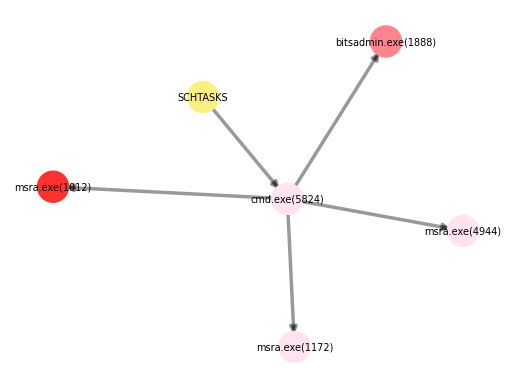

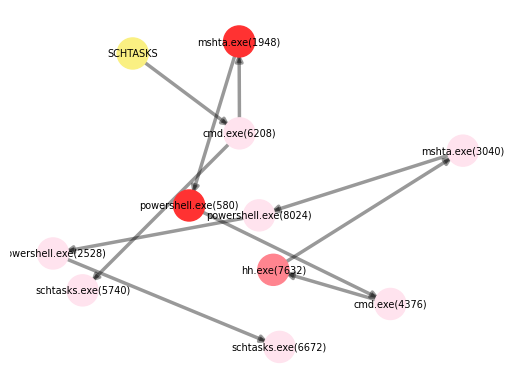

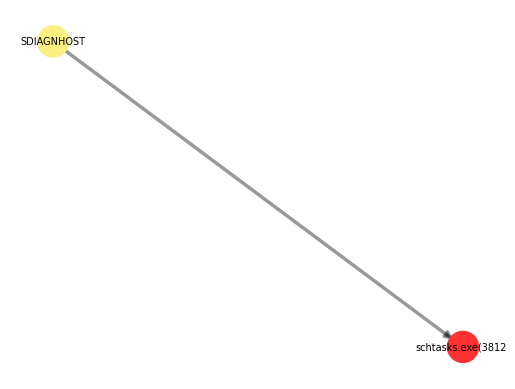

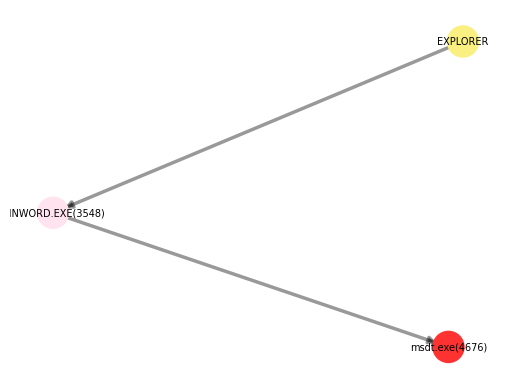

In [478]:
for ps_tree in PROCESS_TREE_LIST:
    draw_process_tree(ps_tree)